In [15]:
from dataset.dataset_pokemon import PokemonData  # Import the new PokemonData class

import matplotlib.pyplot as plt
import numpy as np
from math import sqrt


In [6]:
# Load the data
data = PokemonData()
data.show_images(5)

TypeError: PokemonData.show_images() takes 1 positional argument but 2 were given

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance_ratio_ = None
        self.cumulative_variance_ratio_ = None
        self.cluster_centers_ = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        n_samples = X_centered.shape[0]
        covariance_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        sorted_index = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_index]
        sorted_eigenvectors = eigenvectors[:, sorted_index]

        self.components = sorted_eigenvectors[:, :self.n_components]
        self.explained_variance_ratio_ = sorted_eigenvalues[:self.n_components] / np.sum(sorted_eigenvalues)
        self.cumulative_variance_ratio_ = np.cumsum(self.explained_variance_ratio_)

    def compress(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("The PCA model must be fitted before calling compress.")
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def decompress(self, X_reduced):
        if self.mean is None or self.components is None:
            raise ValueError("The PCA model must be fitted before calling decompress.")
        return np.dot(X_reduced, self.components.T) + self.mean

    def cluster_with_pca(self, X_reduced, Y):
        n_clusters = len(np.unique(Y))
        cluster_centers = np.zeros((n_clusters, X_reduced.shape[1]))

        for digit in range(n_clusters):
            digit_indices = np.where(Y == digit)[0]
            cluster_centers[digit] = np.mean(X_reduced[digit_indices], axis=0)

        self.cluster_centers_ = cluster_centers

        clusters = np.argmin(np.linalg.norm(X_reduced[:, np.newaxis] - self.cluster_centers_, axis=2), axis=1)
        return clusters

    def cluster_with_pca_toy(self, X_reduced, n_clusters, max_iter=100):
        np.random.seed(42)
        initial_indices = np.random.choice(X_reduced.shape[0], n_clusters, replace=False)
        cluster_centers = X_reduced[initial_indices]
        clusters = np.zeros(X_reduced.shape[0])

        for _ in tqdm(range(max_iter), desc="Running Manual Clustering"):
            distances = np.sqrt(((X_reduced[:, np.newaxis] - cluster_centers) ** 2).sum(axis=2))
            clusters = np.argmin(distances, axis=1)

            for i in range(n_clusters):
                points_in_cluster = X_reduced[clusters == i]
                if len(points_in_cluster) > 0:
                    cluster_centers[i] = points_in_cluster.mean(axis=0)

        self.cluster_centers_ = cluster_centers
        return clusters

    def visualize_clusters(self, X_reduced, clusters):
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('Clusters detected by PCA')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

    def plot_sample_images(self, X, clusters, n_clusters):
        plt.figure(figsize=(12, 8))
        for i in range(n_clusters):
            cluster_indices = np.where(clusters == i + 1)[0]
            if len(cluster_indices) == 0:
                continue
            sample_size = min(len(cluster_indices), 10)
            sample_indices = np.random.choice(cluster_indices, sample_size, replace=False)
            for j, index in enumerate(sample_indices):
                plt.subplot(n_clusters, 10, i * 10 + j + 1)
                plt.imshow(X[index].reshape(28, 28), cmap='gray')
                plt.axis('off')
        plt.suptitle('Sample images from each cluster')
        plt.show()

    @staticmethod
    def determine_optimal_components(X, variance_threshold=0.95):
        mean = np.mean(X, axis=0)
        X_centered = X - mean

        n_samples = X_centered.shape[0]
        covariance_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        sorted_eigenvalues = np.sort(eigenvalues)[::-1]
        cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

        optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

        return optimal_components

    def generate_image(self, n_images=1, image_shape=(64, 64, 3)):
        if self.components is None:
            raise ValueError("Le modèle doit être ajusté avant de générer des images.")

        if self.cluster_centers_ is None:
            raise ValueError("Les centres des clusters doivent être définis avant de générer des images.")

        images = []
        for _ in range(n_images):
            cluster_idx = np.random.choice(len(self.cluster_centers_))
            cluster_center = self.cluster_centers_[cluster_idx]
            X_reduced_random = cluster_center + 0.1 * np.random.randn(self.n_components)
            X_generated = self.decompress(X_reduced_random.reshape(1, -1))
            images.append(X_generated)

        return np.array(images).reshape(-1, *image_shape)

    def find_cluster_centers(self, X_reduced, n_clusters):
        initial_indices = np.random.choice(X_reduced.shape[0], n_clusters, replace=False)
        self.cluster_centers_ = X_reduced[initial_indices]

        for _ in range(10):
            clusters = np.argmin(np.linalg.norm(X_reduced[:, np.newaxis] - self.cluster_centers_, axis=2), axis=1)
            new_centers = np.array([X_reduced[clusters == i].mean(axis=0) for i in range(n_clusters)])
            if np.allclose(self.cluster_centers_, new_centers):
                break
            self.cluster_centers_ = new_centers

    def latent_space_walk(self, n_steps=10, n_dimensions=2):
        if self.components is None or self.mean is None:
            raise ValueError("PCA must be fitted before performing latent space walk.")

        # Create a grid in the latent space
        linspace = np.linspace(-3, 3, n_steps)
        grid = np.meshgrid(*[linspace for _ in range(n_dimensions)])
        grid_flat = np.column_stack([g.ravel() for g in grid])

        # Pad the grid points if necessary
        if n_dimensions < self.n_components:
            grid_flat = np.pad(grid_flat, ((0, 0), (0, self.n_components - n_dimensions)))

        # Generate images from the grid points
        generated_images = self.decompress(grid_flat)

        # Plot the generated images
        fig, axes = plt.subplots(n_steps, n_steps, figsize=(15, 15))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(generated_images[i].reshape(28, 28), cmap='viridis')
            ax.axis('off')

        plt.suptitle('Latent Space Walk')
        plt.tight_layout()
        plt.show()

    def plot_scree(self):
        if self.explained_variance_ratio_ is None:
            raise ValueError("The PCA model must be fitted before plotting the scree plot.")

        x_values = range(1, len(self.explained_variance_ratio_) + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, self.explained_variance_ratio_, 'bo-')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Scree Plot')
        plt.grid(True)
        plt.show()


In [81]:
X_train = data.getTrainX()
Y_train = data.getTrainY()
X_test = data.getTestX()
Y_test = data.getTestY()
dataset_image_size = data.image_size


In [82]:
# Reshape the data for PCA
X_pca = X_train.reshape(X_train.shape[0], -1)

# PCA with 2 components
pcap = PCA(n_components=264)
pcap.fit(X_pca)
X_reduced = pcap.compress(X_pca)
X_reconstructed = pcap.decompress(X_reduced)

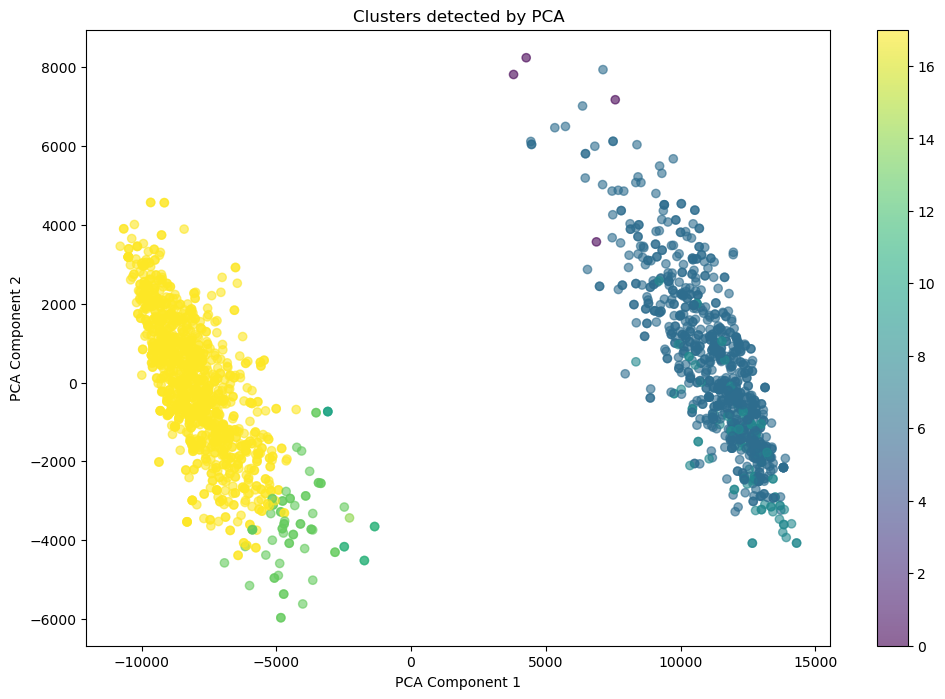

In [59]:
# Cluster and visualize
clusters = pcap.cluster_with_pca(X_reduced, Y_train)
pcap.visualize_clusters(X_reduced, clusters)

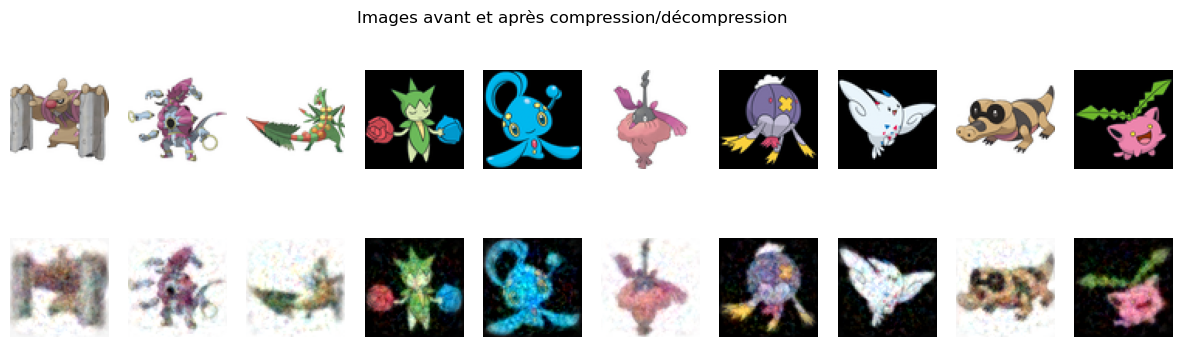

In [56]:
# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
fig.suptitle('Images avant et après compression/décompression')

for i in range(10):
    axes[0, i].imshow(np.clip(X_pca[i].reshape(*dataset_image_size, 3) / 255.0, 0, 1))  # Normalize to [0, 1]
    axes[1, i].imshow(np.clip(X_reconstructed[i].reshape(*dataset_image_size, 3) / 255.0, 0, 1))
    axes[0, i].axis('off')
    axes[1, i].axis('off')

plt.show()


In [78]:
def latent_space_walk(self, n_steps=10, n_dimensions=2, image_shape=(64, 64, 3)):
    if self.components is None or self.mean is None:
        raise ValueError("PCA must be fitted before performing latent space walk.")

    # Use a wider range and non-linear spacing
    linspace = np.concatenate([
        np.linspace(-3, -0.5, n_steps//2),
        np.linspace(0.5, 3, n_steps//2)
    ])

    grid = np.meshgrid(*[linspace for _ in range(n_dimensions)])
    grid_flat = np.column_stack([g.ravel() for g in grid])

    # Pad the grid points if necessary
    if n_dimensions < self.n_components:
        grid_flat = np.pad(grid_flat, ((0, 0), (0, self.n_components - n_dimensions)))

    # Generate images
    generated_images = self.decompress(grid_flat)
    generated_images = np.clip(generated_images, 0, 255).astype(np.uint8)

    # Enhance contrast
    for i in range(len(generated_images)):
        img = generated_images[i].reshape(image_shape)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        generated_images[i] = img.astype(np.uint8)

    # Plot the generated images
    fig, axes = plt.subplots(n_steps, n_steps, figsize=(20, 20))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated_images[i].reshape(image_shape))
        ax.axis('off')

    plt.suptitle('Latent Space Walk', fontsize=24)
    plt.tight_layout()
    plt.show()

# Call the function
latent_space_walk(pcap,n_steps=10, n_dimensions=2, image_shape=(64, 64, 3))

ValueError: cannot reshape array of size 4096 into shape (64,64,3)

In [68]:
# Find cluster centers and generate images
pcap.find_cluster_centers(X_reduced, n_clusters=10)
X_generated = pcap.generate_image(n_images=5, image_shape=dataset_image_size)

plt.imshow(np.clip(X_generated[0].reshape(*dataset_image_size, 3) / 255.0, 0, 1))
plt.title('Generated Image')
plt.axis('off')
plt.show()

TypeError: PCA.generate_image() got an unexpected keyword argument 'image_shape'

In [79]:
# Perform and visualize latent space walk
pcap.latent_space_walk(n_steps=10, n_dimensions=2, image_shape=(64, 64, 3))


TypeError: PCA.latent_space_walk() got an unexpected keyword argument 'image_shape'